<a href="https://www.kaggle.com/code/luisprezsala/batman?scriptVersionId=91379321" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Práctica 1: Análisis exporatorio de datos
---
Minería de Datos

Máster en Ciencia de Datos - Universidad de Alicante

<u>Integrantes:</u>

- Carlos Osman Suazo
- Enrique Morales
- Luis Pérez-Sala
- Alejandro Panagiotidis Arrizabalaga

# Justificación y objetivos
---

En esta primera práctica se nos pidió buscar una serie de datos y realizar un proceso de análisis sobre estos. El tema seleccionado es bucar si existe alguna relación entre el número de centros educativos (colegios y universidades) con los incidentes registrados por la policía en los diferentes distritos de la ciudad de San Francisco. Para ello contamos con diferentes datasets que nos ofrecen:

- Los inicidentes registrados por la policía de San Francisco desde el 2018 hasta la actualidad.
- Datos de las escuelas ubicación, tipo (pública o privada), rango de educación, entre otros.
- Datos de la ubicación de las universidades.
- Datos de los distritos policiales como superficie, nombre y coordenadas.

El objetivo de esta práctica es el de poder extraer información relevante de dicho conjunto de datos, para ello realizaremos una serie de pasos, estos son:

- 1. Análisis exploratorio inicial. 
- 2. Preprocesado de los diferentes conjuntos de datos.
- 3. Análisis de los datos: 
    - Vizualizaciones
    - Mapas
- 4. Conclusión del estudio realizado. 


In [1]:
######## Install Libraries ########
!pip install squarify
!pip install plotly

In [2]:
######## Loading Files ########
import numpy as np
import pandas as pd
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import squarify
from wordcloud import WordCloud
import spacy
import plotly.express as px

DATASET_PATH = '../input/sanfranciscopolicedepartmentincidentreports/'
INCIDENTS_FILE = 'Police_Department_Incident_Reports__2018_to_Present.csv'
SCHOOLS_FILE  = 'Schools.csv'
COLLEGES_FILE = 'Schools_College.csv' 
DISTRICTS_FILE = 'SF_Police_districts.csv'

incidents_df = pd.read_csv(DATASET_PATH + INCIDENTS_FILE)
districts_df = pd.read_csv(DATASET_PATH + DISTRICTS_FILE, sep=',', quotechar='"')
schools_df   = pd.read_csv(DATASET_PATH + SCHOOLS_FILE)
colleges_df  = pd.read_csv(DATASET_PATH + COLLEGES_FILE)

# 1. Análisis exploratorio
----

In [3]:
# Estructura de los datos
print(f'Incidentes data:\n Filas= {incidents_df.shape[0]} \t Columnas= {incidents_df.shape[1]}\n')
print(f' Nombre columnas: \n{list(incidents_df.columns)}\n')
print(f'Escuelas (Schools) data:\n Filas= {schools_df.shape[0]} \t Columnas= {schools_df.shape[1]}\n')
print(f' Nombre columnas: \n{list(schools_df.columns)}\n')
print(f'Universidades (Colleges) data:\n Filas= {colleges_df.shape[0]} \t Columnas= {colleges_df.shape[1]}\n')
print(f' Nombre columnas: \n{list(colleges_df.columns)}\n')
print(f'Distritos data:\n Filas= {districts_df.shape[0]} \t Columnas= {districts_df.shape[1]}\n')
print(f' Nombre columnas: \n{list(districts_df.columns)}\n')

Incidentes data:
 Filas= 566245 	 Columnas= 34

 Nombre columnas: 
['Incident Datetime', 'Incident Date', 'Incident Time', 'Incident Year', 'Incident Day of Week', 'Report Datetime', 'Row ID', 'Incident ID', 'Incident Number', 'CAD Number', 'Report Type Code', 'Report Type Description', 'Filed Online', 'Incident Code', 'Incident Category', 'Incident Subcategory', 'Incident Description', 'Resolution', 'Intersection', 'CNN', 'Police District', 'Analysis Neighborhood', 'Supervisor District', 'Latitude', 'Longitude', 'Point', 'Neighborhoods', 'ESNCAG - Boundary File', 'Central Market/Tenderloin Boundary Polygon - Updated', 'Civic Center Harm Reduction Project Boundary', 'HSOC Zones as of 2018-06-05', 'Invest In Neighborhoods (IIN) Areas', 'Current Supervisor Districts', 'Current Police Districts']

Escuelas (Schools) data:
 Filas= 445 	 Columnas= 21

 Nombre columnas: 
['Campus Name', 'CCSF Entity', 'Lower Grade', 'Upper Grade', 'Grade Range', 'Category', 'Map Label', 'Lower Age', 'Upper A

In [4]:
# Analizamos el número de escuelas por distrito policial
schools_per_district = schools_df.groupby(['Police Districts']).size() \
                                 .to_frame('size').reset_index()
fig = px.pie(schools_per_district, values='size', 
             names='Police Districts',
             labels={ 'Police Districts': 'Distrito policial',  
                'size': 'Núm. escuelas',
             },
             title='Distribución de escuelas por distritos policiales',
             hole=.4)
fig.update_layout(legend_title_text='Distrito policial')
fig.show()

Observando el gráfico anterior podemos ver que el **distrito 8** cuenta con `74` (`16.9%`) escuelas mientras que el **distrito 10** cuenta únicamente con `9` (`2.05%`). Esto nos permite ir viendo ya cómo están distribuidas las escuelas en los diferentes distritos policiales, esta información nos puede resultar muy útil durante el análisis de los resultados.

# 2. Preprocesado de datos
---
A lo largo de este apartado se aplicarán una serie de procesos de limpieza sobre los diferentes conjuntos de datos, esto nos permitirá eliminar tanto fallos en los datos como información innecesaria para el posterior análisis.   

## 2.1 Incidentes

In [5]:
# Eliminamos las siguientes columnas 
incidents_df = incidents_df.drop(['Row ID', 'Incident ID', 'Incident Number', 
                                  'CAD Number', 'Report Type Code', 'Point', 
                                  'Report Type Description', 'Filed Online', 
                                  'CNN', 'Analysis Neighborhood', 
                                  'ESNCAG - Boundary File', 'Neighborhoods',
                                  'HSOC Zones as of 2018-06-05', 
                                  'Invest In Neighborhoods (IIN) Areas',
                                  'Civic Center Harm Reduction Project Boundary', # No existe información de esta columna
                                  'Central Market/Tenderloin Boundary Polygon - Updated'], # No existe información de esta columna
                                 axis=1)

# Convertimos las columnas a tipo fecha
incidents_df['Incident Datetime'] = pd.to_datetime(incidents_df['Incident Datetime'])
incidents_df['Report Datetime'] = pd.to_datetime(incidents_df['Report Datetime'])

print(incidents_df.info())
display(incidents_df.head(2))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 566245 entries, 0 to 566244
Data columns (total 18 columns):
 #   Column                        Non-Null Count   Dtype         
---  ------                        --------------   -----         
 0   Incident Datetime             566245 non-null  datetime64[ns]
 1   Incident Date                 566245 non-null  object        
 2   Incident Time                 566245 non-null  object        
 3   Incident Year                 566245 non-null  int64         
 4   Incident Day of Week          566245 non-null  object        
 5   Report Datetime               566245 non-null  datetime64[ns]
 6   Incident Code                 566245 non-null  int64         
 7   Incident Category             565761 non-null  object        
 8   Incident Subcategory          565761 non-null  object        
 9   Incident Description          566245 non-null  object        
 10  Resolution                    566245 non-null  object        
 11  Intersection 

,Incident Datetime,Incident Date,Incident Time,Incident Year,Incident Day of Week,Report Datetime,Incident Code,Incident Category,Incident Subcategory,Incident Description,Resolution,Intersection,Police District,Supervisor District,Latitude,Longitude,Current Supervisor Districts,Current Police Districts
0,2021-09-29 12:59:00,2021/09/29,12:59,2021,Wednesday,2021-09-29 18:48:00,28150,Malicious Mischief,Vandalism,"Malicious Mischief, Vandalism to Property",Open or Active,NaN,Ingleside,NaN,NaN,NaN,NaN,NaN
1,2021-05-14 01:51:00,2021/05/14,01:51,2021,Friday,2021-05-14 01:57:00,26030,Arson,Arson,Arson,Open or Active,03RD ST \ CUSTER AVE,Bayview,10.0,37.744259,-122.387373,9.0,2.0


## 2.2 Distritos Policiales

In [6]:
# Elimianamos las columnas 'COMPANY', 'Shape_Leng', 'Shape_Le_1'
# ya que no dice que longitud representan.
districts_df = districts_df.drop(['COMPANY', 'Shape_Leng',
                                 'Shape_Le_1'], axis=1)


print(districts_df.info())
display(districts_df.head(2))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   the_geom    10 non-null     object 
 1   DISTRICT    10 non-null     object 
 2   Shape_Area  10 non-null     float64
dtypes: float64(1), object(2)
memory usage: 368.0+ bytes
None


,the_geom,DISTRICT,Shape_Area
0,MULTIPOLYGON (((-122.39186138812263 37.7942468...,SOUTHERN,9.134414e+07
1,MULTIPOLYGON (((-122.38098281360058 37.7648002...,BAYVIEW,2.013846e+08


## 2.3 Escuelas

In [7]:
# Obener las coordenadas de la escuela
# Nos quedamos con las coordenadas separadas por coma
schools_df['Location 1'] = schools_df['Location 1'].str.strip('CA\n()') 

# Separamos la cadena a partir de la coma y asignamos cada valor
# a una nueva columna Latitud y longitud
schools_df[['Latitude', 'Longitude']] = schools_df['Location 1'].str.split(', ', expand=True)

# Convertimos las columnas 'Latitude' y 'Longitude' a tipo float
schools_df[['Latitude', 'Longitude']] = schools_df[['Latitude', 'Longitude']].astype(float)

# Eliminamos la columna 'Location 1' junto con otras que no ofrecen 
# información relevante para el análisis.
schools_df = schools_df.drop(columns=['Location 1', 'Map Label', 'CDS Code', 
                                      'General Type', 'County Name', 'County FIPS', 
                                      'Neighborhoods (old)', 'Zip Codes'], 
                             axis=1)
print(schools_df.info())
display(schools_df.head(2))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 445 entries, 0 to 444
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Campus Name                445 non-null    object 
 1   CCSF Entity                445 non-null    object 
 2   Lower Grade                445 non-null    int64  
 3   Upper Grade                445 non-null    int64  
 4   Grade Range                445 non-null    object 
 5   Category                   445 non-null    object 
 6   Lower Age                  445 non-null    int64  
 7   Upper Age                  445 non-null    int64  
 8   Campus Address             445 non-null    object 
 9   Supervisor District        445 non-null    int64  
 10  Fire Prevention Districts  443 non-null    float64
 11  Police Districts           438 non-null    float64
 12  Supervisor Districts       445 non-null    int64  
 13  Latitude                   445 non-null    float64

,Campus Name,CCSF Entity,Lower Grade,Upper Grade,Grade Range,Category,Lower Age,Upper Age,Campus Address,Supervisor District,Fire Prevention Districts,Police Districts,Supervisor Districts,Latitude,Longitude
0,"Milk, Harvey Milk Childrens Center",SFUSD,-2,-1,PK,USD PreK,3,4,"841 ELLIS ST, SAN FRANCISCO CA 94117",6,7.0,9.0,9,37.783802,-122.420105
1,Mckinley Elementary School,SFUSD,0,5,K-5,USD Grades K-5,5,10,"1025 14TH ST, San Francisco, CA 94114",8,15.0,5.0,5,37.766884,-122.436279


Después de terminar el preproceso del conjunto de datos de las escuelas podemos observar que, de un total de `445`, contamos únicamente con `438` asociadas a un distrito policial, esto nos deja con siete (`7`) escuelas que no tenemos el distrito al que pertenece, estas no serán eliminadas de los datos ya que a nivel de vizualización en un mapa podrán ser ubicadas. 

## 2.4 Universidades

In [8]:
# Eliminamos las columnas: 
# webaddress, campus, phone, st_area_sh y st_length_
colleges_df = colleges_df.drop(['webaddress', 'campus', 'phone', 
                                'st_area_sh', 'st_length_'], axis=1)
# Renombramos las columnas: 
# the_geom -> geom_coordinates
# institutio -> college_name
colleges_df =colleges_df.rename(columns={'the_geom': 'geom_coordinates', 
                                         'institutio': 'college_name'})
print(colleges_df.info())
display(colleges_df.head(2))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46 entries, 0 to 45
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   geom_coordinates  46 non-null     object
 1   college_name      46 non-null     object
 2   address           46 non-null     object
dtypes: object(3)
memory usage: 1.2+ KB
None


,geom_coordinates,college_name,address
0,MULTIPOLYGON (((-122.41422959861103 37.7811707...,University of California Hastings College of Law,100 McAllister St
1,MULTIPOLYGON (((-122.41529196158669 37.7812009...,University of California Hastings College of Law,198 McAllister St


Una vez tenemos completado el preprocesado de los datos, se podría pensar que los datos de _incidentes_, _distritos policiales_ y _escuelas_, pero se decidió no unir todos estos datasets y trabajar con cada dataset por separado, esto se debe a que al unir dichos datasets se duplicarían registros de incidentes por cada escuela del distrito en el que ocurrió este.

# 3. Visualización de Datos
---

## 3.1 Total de crímenes según el día de la semana



In [9]:
# Seleccionamos un años en este caso 2019 
incidents_2019 = incidents_df[incidents_df['Incident Datetime'].between('2019-01-01', '2019-12-31')]

# Agrupamos por día de la semana
incidents_19_grp = incidents_2019.groupby(['Incident Category', 'Incident Day of Week']).size() \
                                 .to_frame('total_incidents').reset_index()

cats = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'] 
incidents_19_grp['Incident Day of Week'] = pd.Categorical(incidents_19_grp['Incident Day of Week'], categories=cats, ordered=True)
incidents_19_grp = incidents_19_grp.sort_values('Incident Day of Week')


px.bar(incidents_19_grp, x="Incident Day of Week", y="total_incidents", color="Incident Category",
      title="Total de crimes en un año segun el día de la semana", labels={"total_incidents": "Total incidentes"})

Observando la gráfica de incidentes según el día de la semana en un año competo, comprobamos que los viernes son el día en que más incidentes se registran, y el domingo en el que menos, también destaca que durante todo el año el incidente que más ocurre durante los días de la semana es el de `Lacerny left` (Hurto). A partir de esta gráfica no podemos sacar una relacíón clara entre el número de incidentes y las intituciones educativas mas allá que el último día lectivo es en que mayor incidentes ocurren.

## 3.2 Serie temporal: Evolución del número de incidentes por año y mes

Para comenzar sería interesante analizar la evoluión de los incidentes en los últimos años mediante series temporales en función de los meses. Esto puede responder a ciertas preguntas inciales como:
* ¿En qué meses se cometen más incidentes?
* ¿En la época de verano suele haber más robos?
* ¿Cómo ha afectado la pandemia del COVID-19?

<AxesSubplot:title={'center':'Número de incidentes por Mes/Año'}, xlabel='Mes', ylabel='Número de incidentes'>

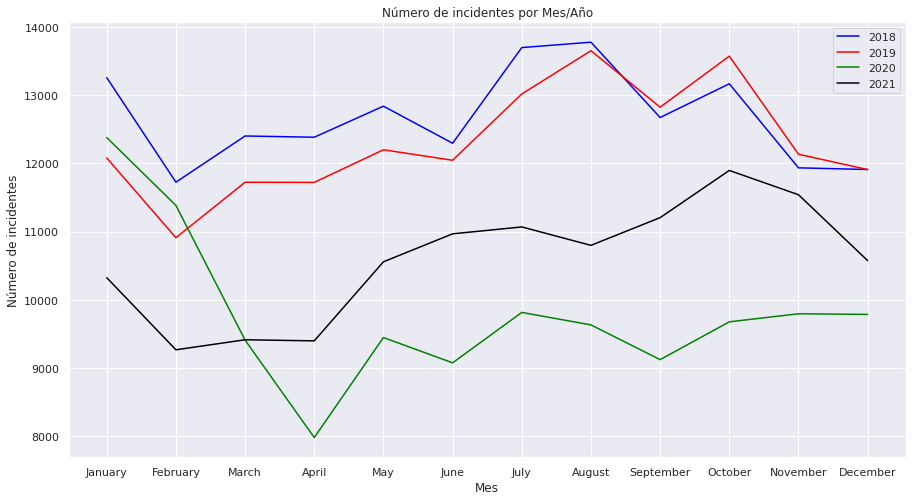

In [10]:
incidents_df = incidents_df.sort_values('Incident Datetime')

incidents_2018 = incidents_df[incidents_df['Incident Datetime'].between('2018-01-01', '2018-12-31')]
incidents_2019 = incidents_df[incidents_df['Incident Datetime'].between('2019-01-01', '2019-12-31')]
incidents_2020 = incidents_df[incidents_df['Incident Datetime'].between('2020-01-01', '2020-12-31')]
incidents_2021 = incidents_df[incidents_df['Incident Datetime'].between('2021-01-01', '2021-12-31')]
incidents_2022 = incidents_df[incidents_df['Incident Datetime'].between('2022-01-01', '2022-12-31')]

monthly_2018 = incidents_2018.groupby(incidents_2018['Incident Datetime'].dt.strftime('%B'))['Incident Datetime'].count()
monthly_2019 = incidents_2019.groupby(incidents_2019['Incident Datetime'].dt.strftime('%B'))['Incident Datetime'].count()
monthly_2020 = incidents_2020.groupby(incidents_2020['Incident Datetime'].dt.strftime('%B'))['Incident Datetime'].count()
monthly_2021 = incidents_2021.groupby(incidents_2021['Incident Datetime'].dt.strftime('%B'))['Incident Datetime'].count()
monthly_2022 = incidents_2022.groupby(incidents_2022['Incident Datetime'].dt.strftime('%B'))['Incident Datetime'].count()

months_sorted = sorted(monthly_2021.keys(), key=lambda day: datetime.strptime(day, "%B"))

sorted_2018 = [] 
sorted_2019 = []
sorted_2020 = []
sorted_2021 = []
sorted_2022 = []

for month in months_sorted:
    sorted_2018.append(monthly_2018[month])
    sorted_2019.append(monthly_2019[month])
    sorted_2020.append(monthly_2020[month])
    sorted_2021.append(monthly_2021[month])

sns.set_theme(style="darkgrid")

sns.set(rc={'figure.figsize':(15,8)})

plt.title("Número de incidentes por Mes/Año")
plt.xlabel("Mes")
plt.ylabel("Número de incidentes")

sns.lineplot(x=months_sorted, y=sorted_2018, color='blue',  legend='brief', label=str('2018'))
sns.lineplot(x=months_sorted, y=sorted_2019, color='red',   legend='brief', label=str('2019'))
sns.lineplot(x=months_sorted, y=sorted_2020, color='green', legend='brief', label=str('2020'))
sns.lineplot(x=months_sorted, y=sorted_2021, color='black', legend='brief', label=str('2021'))

Observando la serie temporal anterior apreciamos que el número de incidentes ha sufrido un descenso muy pronunciado en la época del confinamiento debido al COVID-19 entre los meses febrero y abril del año 2020 con respecto a los años anteriores. 

No obstante, a partir de abril podemos apreciar que la tendencia que inicialmente se había roto hasta abril, se recupera a partir de mayo debido a la relajación de medidas del gobierno.

También apreciamos un aumento considerable de incidentes en los meses de julio y agosto históricamente.

## 3.3 Comparación incidentes época COVID-19/No-COVID-19

En esta sección analizaremos qué tipos de incidentes ocurrieron durante la etapa de confinamiento y los compararemos con los del año anterior.

El objetivo es mostrar el TOP-5 de incidentes que más han variado proporcionalmente en la distribución de ambas épocas.  

,Incident,Not COVID incident count,Not COVID Percentage,COVID incident count,COVID Percentage,Difference (ABS)
0,Larceny Theft,4975,0.304412,2517,0.231661,0.072750
5,Burglary,714,0.043688,988,0.090934,0.047246
6,Motor Vehicle Theft,589,0.036040,707,0.065071,0.029031
10,Lost Property,689,0.042159,179,0.016475,0.025684
2,Malicious Mischief,1020,0.062412,956,0.087989,0.025577


[Text(0.5, 1.0, '2020 March-May')]

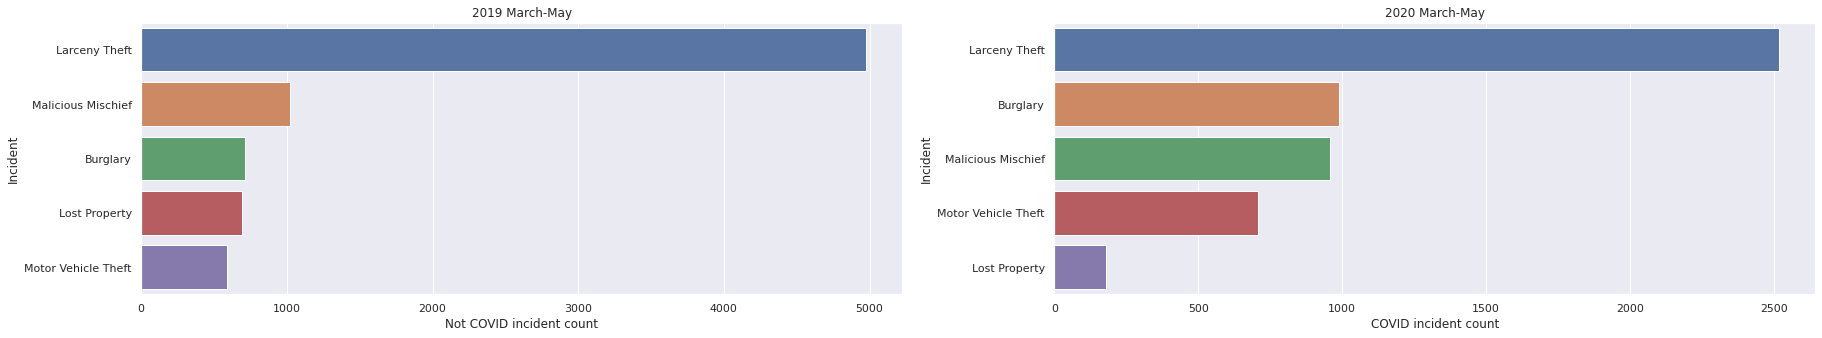

In [11]:
############ COVID ############
not_covid_data_frame = incidents_2019[incidents_2019['Incident Datetime'].between('2019-03-20', '2019-05-01')]
covid_data_frame = incidents_2020[incidents_2020['Incident Datetime'].between('2020-03-20', '2020-05-01')]

not_covid_order = pd.Categorical(not_covid_data_frame['Incident Category'].value_counts().index)
covid_order = pd.Categorical(covid_data_frame['Incident Category'].value_counts().index)

difference_dataframe = pd.DataFrame(columns=['Incident', 'Not COVID incident count','Not COVID Percentage',
                                              'COVID incident count', 'COVID Percentage', 'Difference (ABS)'])

for incident in incidents_df['Incident Category'].value_counts().iteritems():
    not_covid_incident_count = (not_covid_data_frame['Incident Category'] == incident[0]).sum()
    covid_incident_count     = (covid_data_frame['Incident Category'] == incident[0]).sum()
    
    not_covid_percentage = not_covid_incident_count / len(not_covid_data_frame)
    covid_percentage     = covid_incident_count / len(covid_data_frame)

    difference_dataframe = difference_dataframe.append({'Incident': incident[0],
                                                        'Not COVID incident count': not_covid_incident_count,
                                                        'Not COVID Percentage': not_covid_percentage,
                                                        'COVID incident count': covid_incident_count,
                                                        'COVID Percentage': covid_percentage,
                                                        'Difference (ABS)': np.abs(covid_percentage - not_covid_percentage)},
                                                       ignore_index=True)

difference_dataframe = difference_dataframe.sort_values('Difference (ABS)', ascending = False)[:5]
not_covid_display = difference_dataframe.sort_values('Not COVID incident count', ascending = False)
covid_display     = difference_dataframe.sort_values('COVID incident count', ascending = False)

display(difference_dataframe)

sns.set(rc={'figure.figsize':(30,5)})
fig, ax =plt.subplots(1,2)
sns.barplot(data=not_covid_display, x='Not COVID incident count', y="Incident", ax=ax[0]).set(title='2019 March-May')
sns.barplot(data=covid_display, x='COVID incident count', y="Incident", ax=ax[1]).set(title='2020 March-May')

Observamos que el número de hurtos en la época del confinamiento ha descendido considerablemente con respecto a la misma época del año anterior, llegando incluso a la mitad.

Los robos de vehículos en la época del confinamiento representan un `6.5%` total de los incidentes, mientras que el año anterior era un `3.6%`.

Los allanamientos de morada han aumentado un `4%` con respecto al anterior año, seguido de un descenso del `2%` de los actos de vandalismo.

Parece lógico que estos cambios en la distribución de los delitos se hayan producido por la falta de movilidad y refugio de las personas en sus casas.

## 3.4 Comparación incidentes Febrero/Octubre 2021

Debido a que en la gráfica temporal mostrada anteriormente se aprecia que en el año 2021 se producen muchos más incidentes en octubre que en febrero, analizaremos qué tipo de incidentes se cometen en ambos periodos.

El objetivo es mostrar el TOP-5 de incidentes que más han variado proporcionalmente en la distribución de ambas épocas.  

,Incident,February incident count,February Percentage,October incident count,October Percentage,Difference (ABS)
0,Larceny Theft,3859,0.334257,2049,0.228990,0.105268
5,Burglary,619,0.053616,784,0.087617,0.034001
7,Recovered Vehicle,467,0.040450,529,0.059119,0.018669
1,Other Miscellaneous,736,0.063751,715,0.079906,0.016156
11,Drug Offense,183,0.015851,224,0.025034,0.009183


[Text(0.5, 1.0, 'October')]

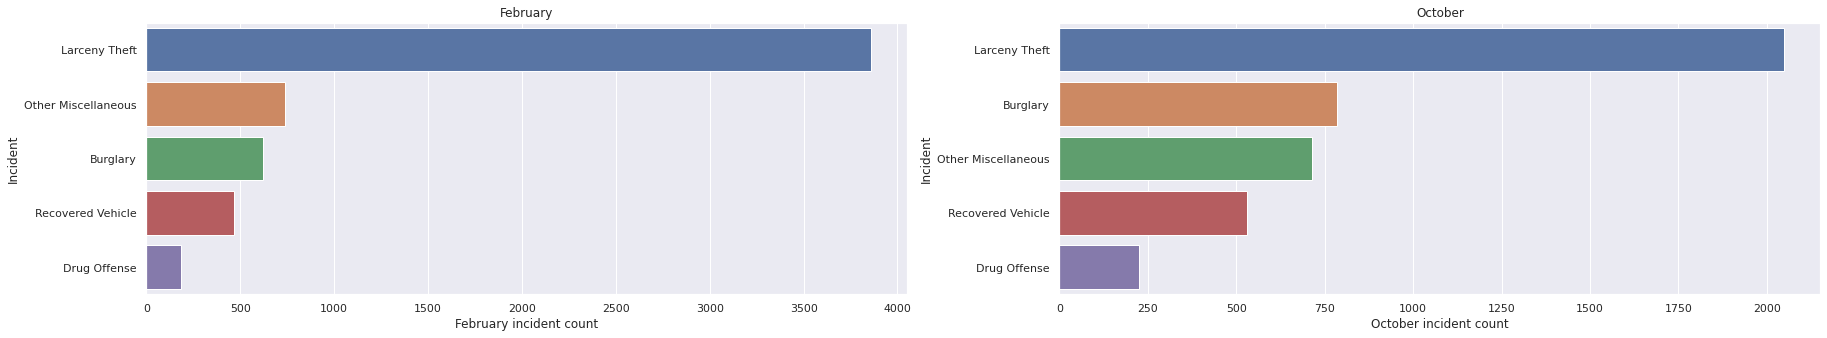

In [12]:
############ SUMMER ############
february_data_frame = incidents_2021[incidents_2021['Incident Datetime'].between('2021-10-01', '2021-10-31')]
october_data_frame = incidents_2021[incidents_2021['Incident Datetime'].between('2021-02-01', '2021-02-28')]

february_order = pd.Categorical(february_data_frame['Incident Category'].value_counts().index)
october_order = pd.Categorical(october_data_frame['Incident Category'].value_counts().index)


difference_dataframe = pd.DataFrame(columns=['Incident', 'February incident count','February Percentage',
                                              'October incident count', 'October Percentage', 'Difference (ABS)'])

for incident in incidents_df['Incident Category'].value_counts().iteritems():
    february_incident_count = (february_data_frame['Incident Category'] == incident[0]).sum()
    october_incident_count  = (october_data_frame['Incident Category'] == incident[0]).sum()
    
    february_percentage = february_incident_count / len(february_data_frame)
    october_percentage    = october_incident_count / len(october_data_frame)

    difference_dataframe = difference_dataframe.append({'Incident': incident[0],
                                                        'February incident count': february_incident_count,
                                                        'February Percentage': february_percentage,
                                                        'October incident count': october_incident_count,
                                                        'October Percentage': october_percentage,
                                                        'Difference (ABS)': np.abs(october_percentage - february_percentage)},
                                                       ignore_index=True)

difference_dataframe = difference_dataframe.sort_values('Difference (ABS)', ascending = False)[:5]
february_display = difference_dataframe.sort_values('February incident count', ascending = False)
october_display  = difference_dataframe.sort_values('October incident count', ascending = False)

display(difference_dataframe)  
    
    
sns.set(rc={'figure.figsize':(30,5)})
fig, ax =plt.subplots(1,2)
sns.barplot(data=february_display, x='February incident count', y="Incident", ax=ax[0]).set(title='February')
sns.barplot(data=october_display, x='October incident count', y="Incident", ax=ax[1]).set(title='October')

Observando la tabla y la gráfica,

Podemos apreciar que aumentan los allanamientos de morada en la época de octubre en un `3.4%` en la distribución con respecto a febrero.

## 3.5 Incidentes más frecuentes Día/Noche

Analizaremos qué incidentes son más frecuentes en las horas diurnas y nocturnas mostrando un TOP-5 de aquellos que más varían comparando las distribuciones, considerando el día de seis de la mañana a seis de la tarde.

In [13]:
daily_data_frame   = incidents_df[incidents_df['Incident Datetime'].dt.strftime("%H:%M:%S").between('07:00:00', '18:00:00')]
nightly_data_frame = incidents_df[incidents_df['Incident Datetime'].dt.strftime("%H:%M:%S").between('18:00:01', '23:59:59')]
nightly_data_frame = nightly_data_frame.append(incidents_df[incidents_df['Incident Datetime'].dt.strftime("%H:%M:%S").between('00:00:00', '06:59:59')])

,Incident,Daily incident count,Daily Percentage,Nightly incident count,Nightly Percentage,Difference (ABS)
5,Burglary,13360,0.041951,18917,0.076347,0.034397
2,Malicious Mischief,18080,0.056771,20133,0.081255,0.024484
3,Non-Criminal,21704,0.068151,12687,0.051204,0.016947
11,Drug Offense,9618,0.030201,3597,0.014517,0.015683
8,Warrant,11153,0.035021,6254,0.025241,0.009780


[Text(0.5, 1.0, 'Nightly')]

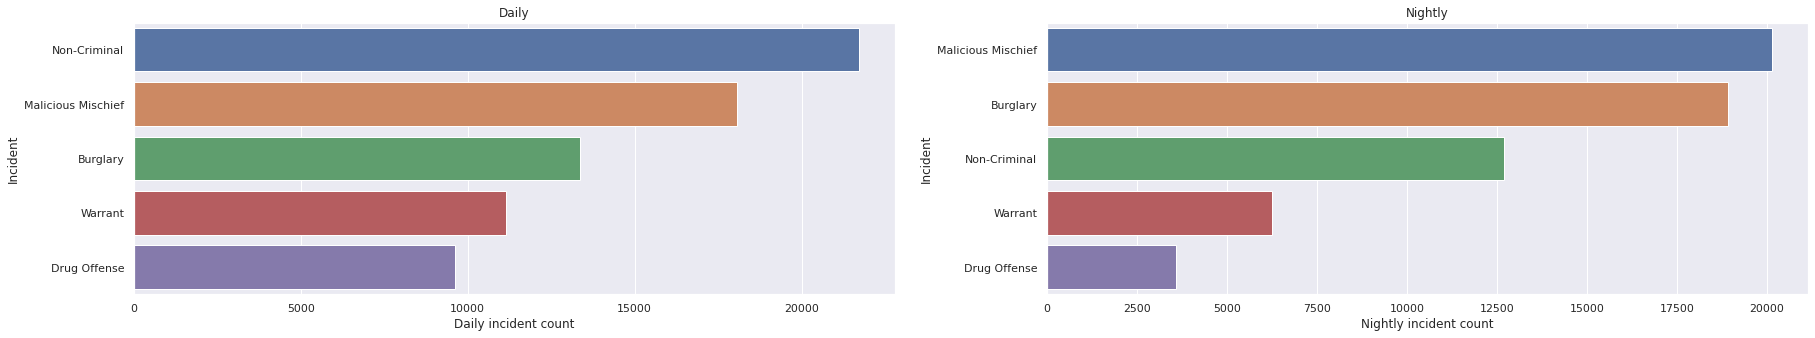

In [14]:
difference_dataframe = pd.DataFrame(columns=['Incident', 'Daily incident count','Daily Percentage',
                                              'Nightly incident count', 'Nightly Percentage', 'Difference (ABS)'])

for incident in incidents_df['Incident Category'].value_counts().iteritems():
    daily_incident_count = (daily_data_frame['Incident Category'] == incident[0]).sum()
    nightly_incident_count  = (nightly_data_frame['Incident Category'] == incident[0]).sum()
    
    daily_percentage = daily_incident_count / len(daily_data_frame)
    nightly_percentage    = nightly_incident_count / len(nightly_data_frame)

    difference_dataframe = difference_dataframe.append({'Incident': incident[0],
                                                        'Daily incident count': daily_incident_count,
                                                        'Daily Percentage': daily_percentage,
                                                        'Nightly incident count': nightly_incident_count,
                                                        'Nightly Percentage': nightly_percentage,
                                                        'Difference (ABS)': np.abs(nightly_percentage - daily_percentage)},
                                                       ignore_index=True)

difference_dataframe = difference_dataframe.sort_values('Difference (ABS)', ascending = False)[:5]
daily_display = difference_dataframe.sort_values('Daily incident count', ascending = False)
nightly_display  = difference_dataframe.sort_values('Nightly incident count', ascending = False)

display(difference_dataframe)  
    
sns.set(rc={'figure.figsize':(30,5)})
fig, ax =plt.subplots(1,2)
sns.barplot(data=daily_display, x='Daily incident count', y="Incident", ax=ax[0]).set(title='Daily')
sns.barplot(data=nightly_display, x='Nightly incident count', y="Incident", ax=ax[1]).set(title='Nightly')

Observamos que los actos vandálicos nocturnos aumentan su representación en la distribución en un 3.4% con respecto a los diurnos.

Los incidentes No Criminales se reducen hasta la mitad llegando a reducirse en un 1% en la representación de la distribución.

## 3.6 Revisaremos la correlación de los datasets utilizando matrices de correlación:
1. Police Departmen Incidents
2. Schools College
3. Schools

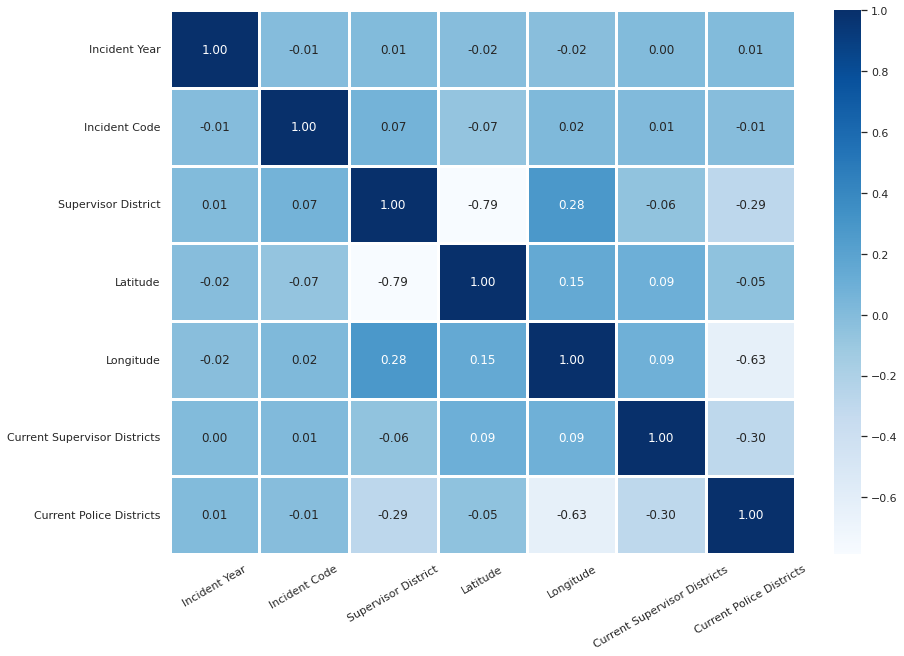

In [15]:
#print(incidents_df.info())
#print(schools_df.info())
#print(colleges_df.info())


incidents = incidents_df.copy()

plt.figure(figsize=(14, 10))
sns.heatmap(incidents.corr('spearman'), annot=True, fmt='.2f', linewidth=3, cmap='Blues')
plt.yticks(rotation=0)
plt.xticks(rotation=30)
plt.show()

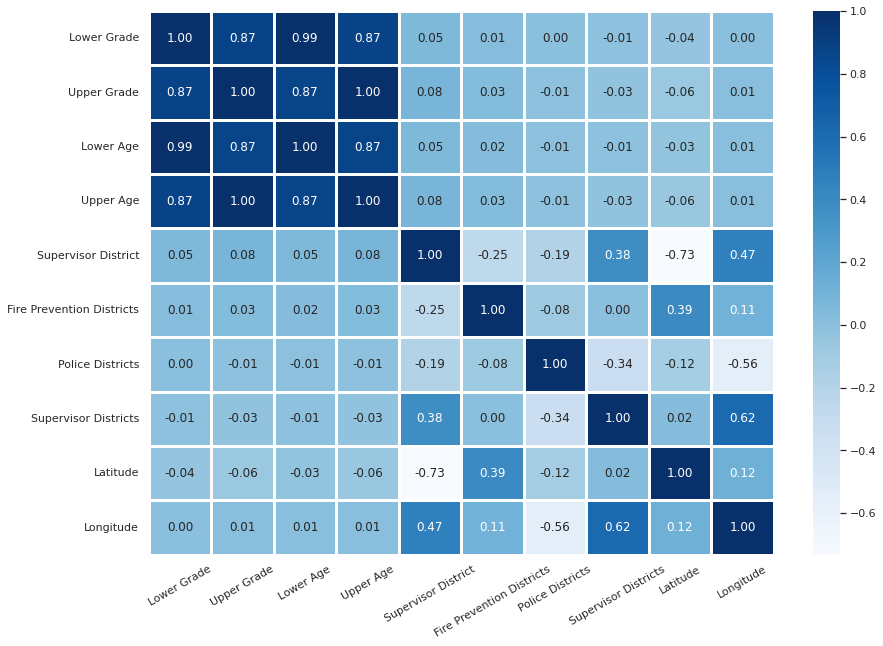

In [16]:
schools = schools_df.copy()

plt.figure(figsize=(14, 10))
sns.heatmap(schools.corr('spearman'), annot=True, fmt='.2f', linewidth=3, cmap='Blues')
plt.yticks(rotation=0)
plt.xticks(rotation=30)
plt.show()

## 3.7 Diagrama de Arbol de las "Categorías de Crimen" mas frecuentes

El siguiente diagráma de árbol muestra una distribución de la proporción de las categorías de incidentes más comunes en el área de San Francisco, siendo el más cómun el "Larceny Theft" "Hurto Robo". Estas categorías no nos brindan suficiente información del tipo de incidente, por lo cual en la siguiente celda analizaremos las sub-categorías, estas brindan mejores descripciones de lo acontecido.

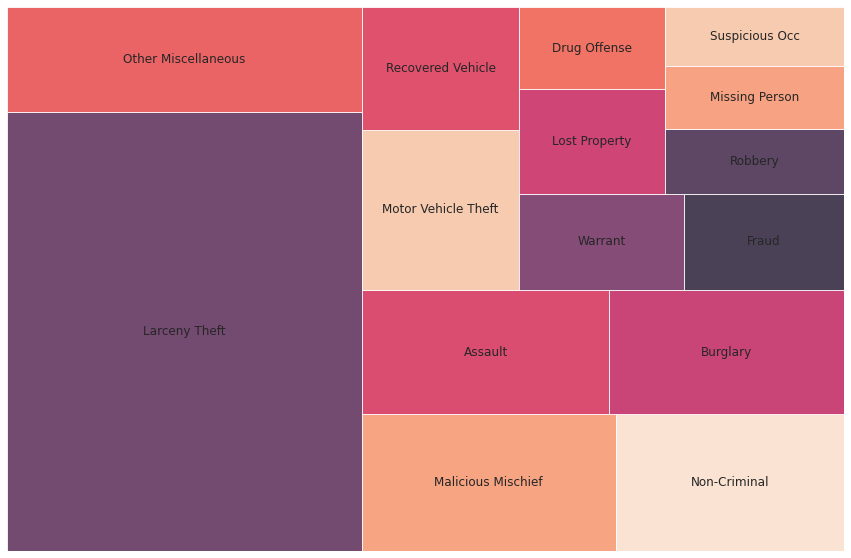

In [17]:
incidents_category = incidents_df['Incident Category'].value_counts()[:15].copy()

plt.figure(figsize=(15,10))
squarify.plot(sizes=incidents_category.values, label=incidents_category.index, alpha=.8)
plt.axis('off')
plt.show()

## 3.8 Diagrama de Arbol de las "Subcategorías de Crimen" mas frecuentes

El siguiente diagráma de árbol muestra una distribución de la proporción de las subcategorías de incidentes más comunes en el área de San Francisco, siendo el más cómun el "Larceny - From Vehicle" "Hurto - De Vehicule ", podemos que otra de las sucategorías mayoritarias es "Other", esta categoría no aporta información y es un label utilizado para clasificar todo no que no tiene un sentido para la policía. Por esto procederemos a remover esta subcategoría y así dejar paso a una subcategoría que sea más explicativa.

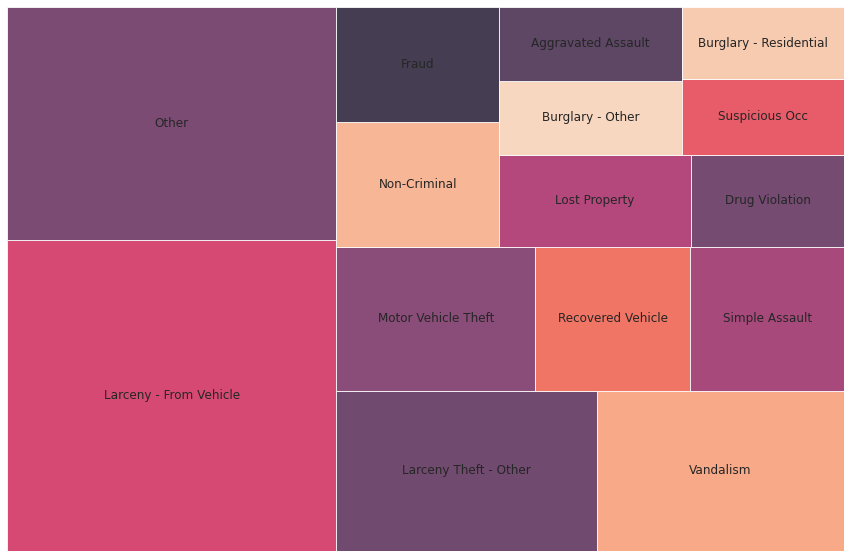

In [18]:
incidents_category = incidents_df['Incident Subcategory'].value_counts()[:15].copy()

plt.figure(figsize=(15,10))
squarify.plot(sizes=incidents_category.values, label=incidents_category.index, alpha=.8)
plt.axis('off')
plt.show()

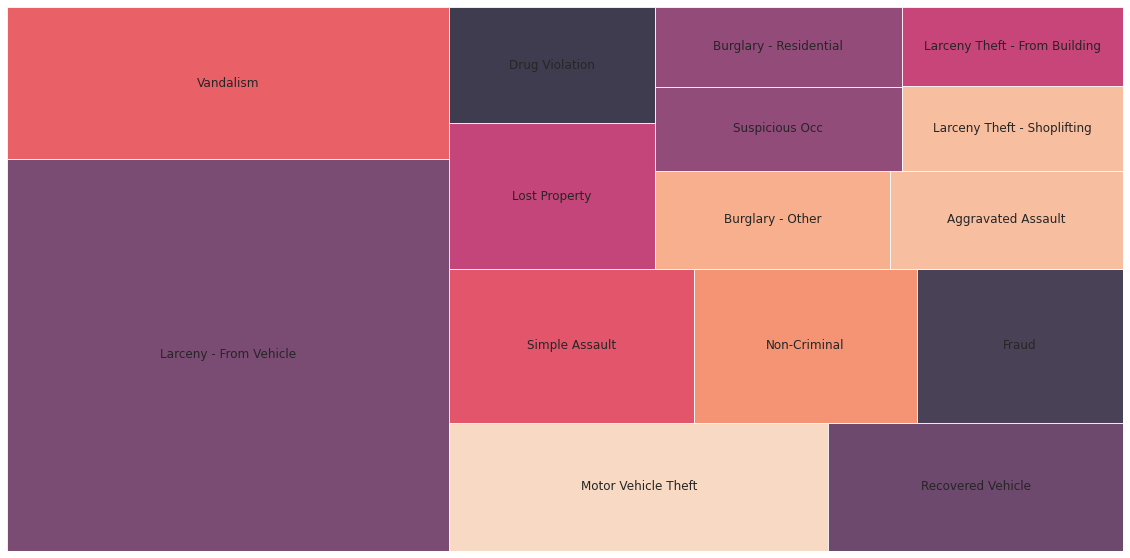

In [19]:
incidents_category = incidents_df[~incidents_df['Incident Subcategory'].isin(['Other','Larceny Theft - Other'])]['Incident Subcategory'].value_counts()[:15].copy()

plt.figure(figsize=(20,10))
squarify.plot(sizes=incidents_category.values, label=incidents_category.index, alpha=.8)
plt.axis('off')
plt.show()

Después de haber quitado las subcategorías que no aportaban información en su label, por ejemplo Other y Larceny - Other, podemos observar que "Larceny - From Vehicle" es de las subcategorías más comunes. Esto podría brindar suficiente información para poder realizar campañas de concientización para sugerir a las personas no dejar objetos en los coches. 

## 3.9 Nube de palabras para análizar las descripciones de los incidentes reportados

In [20]:
nlp = spacy.load('en_core_web_sm') # Utilizamo el SM porque no se puede cargar el Medium

list_words = [x.split() for x in incidents_df['Incident Description'].values]  # Obtenemos todas las palabras individuales para cada nombre
list_words = ' '.join([word for sublist in list_words for word in sublist])  # Las juntamos todas en un único texto
list_words = list_words[:1000000]

corpus = nlp(list_words)  # Procesamos las palabras con SpaCy
tokens = [w.lower_ for w in corpus if (not w.is_space and not w.is_punct)]  # Eliminamos espacios en blanco y signos de puntuación
corpus = ' '.join(tokens)  # Ya tenemos la lista de palabras limpia

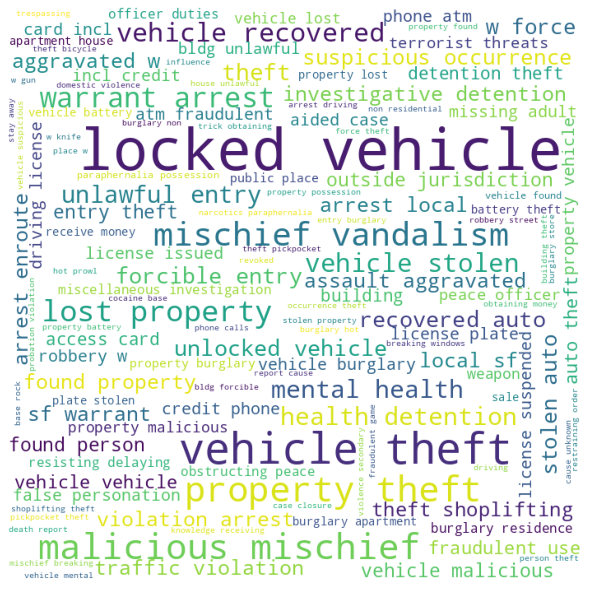

In [21]:
wordcloud = WordCloud(width=700, height=700, background_color='white', min_font_size=10).generate(corpus)
plt.figure(figsize=(8, 8), facecolor=None) 
plt.imshow(wordcloud) 
plt.axis('off') 
plt.tight_layout(pad=0) 
plt.show()

En este caso hacemos un análisis de las descripciones de todas los incidentes, para poder identificar en un Word Cloud cuales son las palabras más comunes. En las descripciones podemos observar que "Locked Vehicle" "Vehicle Theft" y "Property Theft"

## 3.10 Calculamos el tiempo promedio de reporte por categoría de incidente

Este análisis se centra en ver el tiempo promedio que demoran las personas en reportar un incidente, tomando en consideración la fecha en la ocurrió el incidente menos la fecha de reporte en las oficinas de la policia. 

In [22]:
# Calcular el tiempo promedio de reporte de un incidente y ver si tiene algún sentido.
# obtenemos la diferencia de tiempo entre la fecha de reporte y la fecha del incidente.
incidents_df['Difference Date'] = abs(incidents_df['Incident Datetime'] - incidents_df['Report Datetime'])

## 3.11 Tiempo promedio de reporte
Este es el top 15 de las categorías de incidentes que más demoran en reportarse, con este análisis tenemos que el tráfico de humanos ha demorado más en reportarse. Hay que considerar que en el dataset solo se cuenta con un registro. Los delitos de malversación tienen un promedio tiempo de reporte arriba de los 50 días.

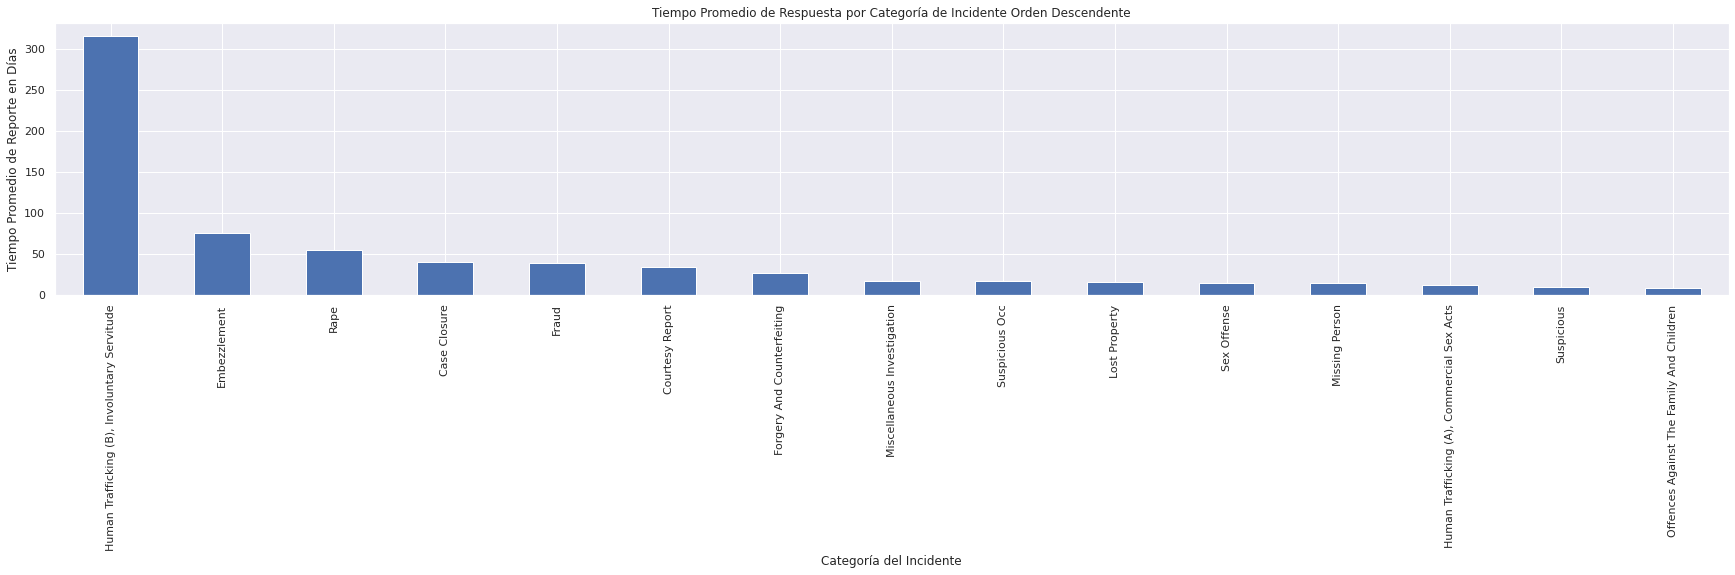

In [23]:
df_Test = incidents_df.groupby('Incident Category')['Difference Date'].mean().sort_values(ascending = False)[:15].astype('timedelta64[h]') / 24
df_Test.plot(kind = 'bar', title = 'Tiempo Promedio de Respuesta por Categoría de Incidente Orden Descendente', rot = 90)

plt.xlabel('Categoría del Incidente')
plt.ylabel('Tiempo Promedio de Reporte en Días')
plt.show()

Este es el top 15 de las categorías de incidentes que más rápido se reportan. Por ejemplo el vandalismo tiene un tiempo promedio de reporte arriba de 2.5 días 

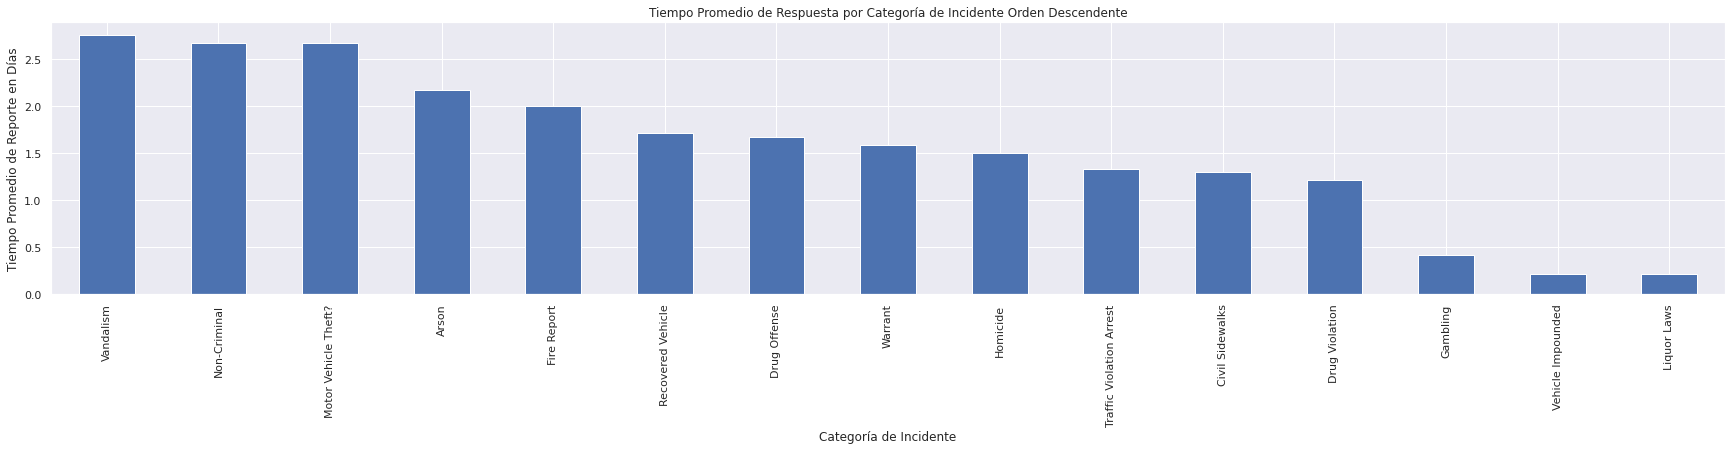

In [24]:
df_Test = incidents_df.groupby('Incident Category')['Difference Date'].mean().sort_values()[:15].sort_values(ascending = False).astype('timedelta64[h]') / 24
df_Test.plot(kind = 'bar', title = 'Tiempo Promedio de Respuesta por Categoría de Incidente Orden Descendente', rot = 90)

plt.xlabel('Categoría de Incidente')
plt.ylabel('Tiempo Promedio de Reporte en Días')
plt.show()

## 3.12 Plots de crímenes por código ID

In [25]:
import pandas as pd
import folium
from folium import plugins

df_og = pd.read_csv("../input/sanfranciscopolicedepartmentincidentreports/Police_Department_Incident_Reports__2018_to_Present.csv")
df=df_og.groupby(['Police District', 'Incident Code'], as_index=False).size()
df['Police District'] = df['Police District'].str.upper()
names_df = df['Police District'].unique()
id_crimes = df['Incident Code'].unique()

####### all crimes id #######
#for id_name in id_crimes:
#    df_counts = pd.DataFrame()
#    
#    for it in names_df:
        #df_counts = df_counts.append(df.loc[(df['Police District'] == it) & (df['Incident Code'] == id_name)].nlargest(1, columns=['size']))
    
    # df_counts = df_counts.drop(index=3021)
    
    #sf_map = folium.Map()
    #sf_map = folium.Map(location=[37.7749, -122.4194], zoom_start=12)
    #folium.TileLayer('stamenterrain').add_to(sf_map)
    #sf_geo = r'../input/sfgeojson/san-francisco.geojson'
    
    #sf_map.choropleth(
    #    geo_data=sf_geo,
    #    data=df_counts,
    #    columns=['Police District', 'size'],
    #    key_on='feature.properties.DISTRICT',
    #    fill_color='YlOrRd', 
    #    fill_opacity=0.7, 
    #    line_opacity=0.4,
    #    legend_name='Number of crimes',
    #    name=id_name
    #)
    
    #loc = 'Incident Code: '+str(id_name)
    #title_html = '''
    #             <h3 align="center" style="font-size:16px"><b>{}</b></h3>
    #             '''.format(loc)   
    #sf_map.get_root().html.add_child(folium.Element(title_html))
    
    #sf_map.save(str(id_name)+"_"+"SFmap.html")

## 3.13 Crímenes más cometidos con código ID por distrito

In [26]:
####### top crimes id by district #######

# bayview, central, ingleside,  mission, northern, parkside, richmond, southern, taraval, tenderloin 
lat_ = [37.7311, 37.7782, 37.7235,  37.7599300,  37.8011749, 37.7392,  37.7803, 37.77217, 37.7631, 37.78365]
long_ = [-122.3849, -122.4011, -122.4349, -122.4191376, -122.4090021, -122.484, -122.4715, -122.38909, -122.4546, -122.41295]

df_counts = pd.DataFrame()

for it in names_df:
    df_counts = df_counts.append(df.loc[df['Police District'] == it].nlargest(1, columns=['size']))

df_counts = df_counts.drop(index=3021)

sf_map = folium.Map()
sf_map = folium.Map(location=[37.7749, -122.4194], zoom_start=12)
folium.TileLayer('stamenterrain').add_to(sf_map)
sf_geo = r'../input/sfgeojson/san-francisco.geojson'

#sf_map.choropleth(
#    geo_data=sf_geo,
#    data=df_counts,
#    columns=['Police District', 'size'],
#    key_on='feature.properties.DISTRICT',
#    fill_color='YlOrRd', 
#    fill_opacity=0.7, 
#    line_opacity=0.4,
#    legend_name='Number of crimes',
#    name='Most common crimes by district'
#)

loc = 'Top Crimes by District'
title_html = '''
             <h3 align="center" style="font-size:16px"><b>{}</b></h3>
             '''.format(loc)   
#sf_map.get_root().html.add_child(folium.Element(title_html))

#for lat, lon, value in zip(lat_,long_,df_counts['Incident Code']):
#    folium.Marker(location=[lat,lon],
#                  icon=folium.DivIcon(html=f"""<div style="">{value}</div>""")
#                  ).add_to(sf_map)

# for lat, lon, value in zip(lat_,long_,df_counts['Incident Code']):
#     folium.Marker(location=[lat,lon],
#                   popup=value
#                   ).add_to(sf_map)

# locations = list(zip(lat_, long_))
# cluster = plugins.MarkerCluster(locations=locations,                     
#                popups=df_counts["Incident Code"].tolist())  
# sf_map.add_child(cluster)

#sf_map.save("mc_"+"SFmap.html")

In [27]:
#from IPython.display import IFrame
#IFrame(src='6378_SFmap.html', width=900, height=600)
'''
import IPython
IPython.display.HTML(filename='/path/to/your/filename')
'''

"\nimport IPython\nIPython.display.HTML(filename='/path/to/your/filename')\n"

# 4 Conclusión
---